# Image classification with transfer learning

**Data Pre-processing**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Importing dataset from CIFAR
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


# Load CIFAR-10 dataset and print shapes
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


**Pre-processing classes (y)**

In [2]:
# convert classes into categories with one hot encoding and check shape.
from tensorflow.keras.utils import to_categorical

num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("y_train_cat shape:", y_train.shape)
print("y_test_cat shape:", y_test.shape)

y_train_cat shape: (50000, 10)
y_test_cat shape: (10000, 10)


**Pre-processing images**

to make them compatible with the shapes and scales in our base model


In [3]:
# Reshaping image to be compatible with base model. In batches, to avoid crashing.

"""""
LEARNING
We initially tried model MobileNetV2, which required us to reshape our images, which is not needed with EfficientNetB0


def resize_in_batches_cpu(images, new_size=(160, 160), batch_size=1000):
    resized_batches = []
    with tf.device('/CPU:0'):  # force CPU to avoid GPU OOM
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch_resized = tf.image.resize(batch, new_size).numpy()
            resized_batches.append(batch_resized)
    return np.concatenate(resized_batches, axis=0)

x_train_resized = resize_in_batches_cpu(x_train)
x_test_resized = resize_in_batches_cpu(x_test)

print("Resized shapes:", x_train_resized.shape, x_test_resized.shape)
"""

'""\nLEARNING\nWe initially tried model MobileNetV2, which required us to reshape our images, which is not needed with EfficientNetB0\n\n\ndef resize_in_batches_cpu(images, new_size=(160, 160), batch_size=1000):\n    resized_batches = []\n    with tf.device(\'/CPU:0\'):  # force CPU to avoid GPU OOM\n        for i in range(0, len(images), batch_size):\n            batch = images[i:i+batch_size]\n            batch_resized = tf.image.resize(batch, new_size).numpy()\n            resized_batches.append(batch_resized)\n    return np.concatenate(resized_batches, axis=0)\n\nx_train_resized = resize_in_batches_cpu(x_train)\nx_test_resized = resize_in_batches_cpu(x_test)\n\nprint("Resized shapes:", x_train_resized.shape, x_test_resized.shape)\n'

In [4]:
# Preprocessing our images to fit base model
"""""
LEARNING
We initially tried model MobileNetV2, which required us to reshape our images, which is not needed with EfficientNetB0



# This Keras function is specifically designed to make images compatible with the MobileNetV2 model.
# It involves scaling and shifting pixel values from [0, 255] to [-1, 1], as the model was trained on.


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Preprocess your data
x_train = preprocess_input(x_train_resized)
x_test = preprocess_input(x_test_resized)
"""


'""\nLEARNING\nWe initially tried model MobileNetV2, which required us to reshape our images, which is not needed with EfficientNetB0\n\n\n\n# This Keras function is specifically designed to make images compatible with the MobileNetV2 model.\n# It involves scaling and shifting pixel values from [0, 255] to [-1, 1], as the model was trained on.\n\n\npreprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input\n\n# Preprocess your data\nx_train = preprocess_input(x_train_resized)\nx_test = preprocess_input(x_test_resized)\n'

In [5]:
# Since we are using a Transfer learning technique, we need to merge features and labels into datasets, so that they can be processed correctly at a later stage.

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [6]:

from keras.backend import clear_session
clear_session()

# Create the base model from the pre-trained convnets

In [7]:
# Create the base model from the pre-trained model EfficientNetB0
IMG_SHAPE = (32, 32, 3)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


#Freeze the convolutional base to prevent the weights from being updated during training.
base_model.trainable = False



### Building and training transfer learning model

In [8]:
# First we need to create batched datasets. We will make this as an isolated variable so that we can tweak it to fine-tune the model if needed.
BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



**Apply Global Average Pooling**
to convert feature maps (from base model) to vectors

**Add a classification head**


In [9]:
# Apply Global Average Pooling
# to convert feature maps (from base model) to vectors

# Add a classification head

#image_batch, label_batch = next(iter(train_dataset)) # Removed this line
#feature_batch = base_model(image_batch) # Removed this line
#print(feature_batch.shape) # Removed this line

# Apply Global Average Pooling to convert feature maps to vectors
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch) # This line will be used later in the functional model
#print(f"Feature batch average shape: {feature_batch_average.shape}") # Removed this line


# Classification head: In our case, it will be 10 neurons dense since this is the number of categories.
# Using Softmax as the activation function since this is the ideal choice for classification problems.
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average) # This line will be used later in the functional model
#print(f"Prediction batch shape: {prediction_batch.shape}") # Removed this line

In [10]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


**Now to the model**

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1, 1, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

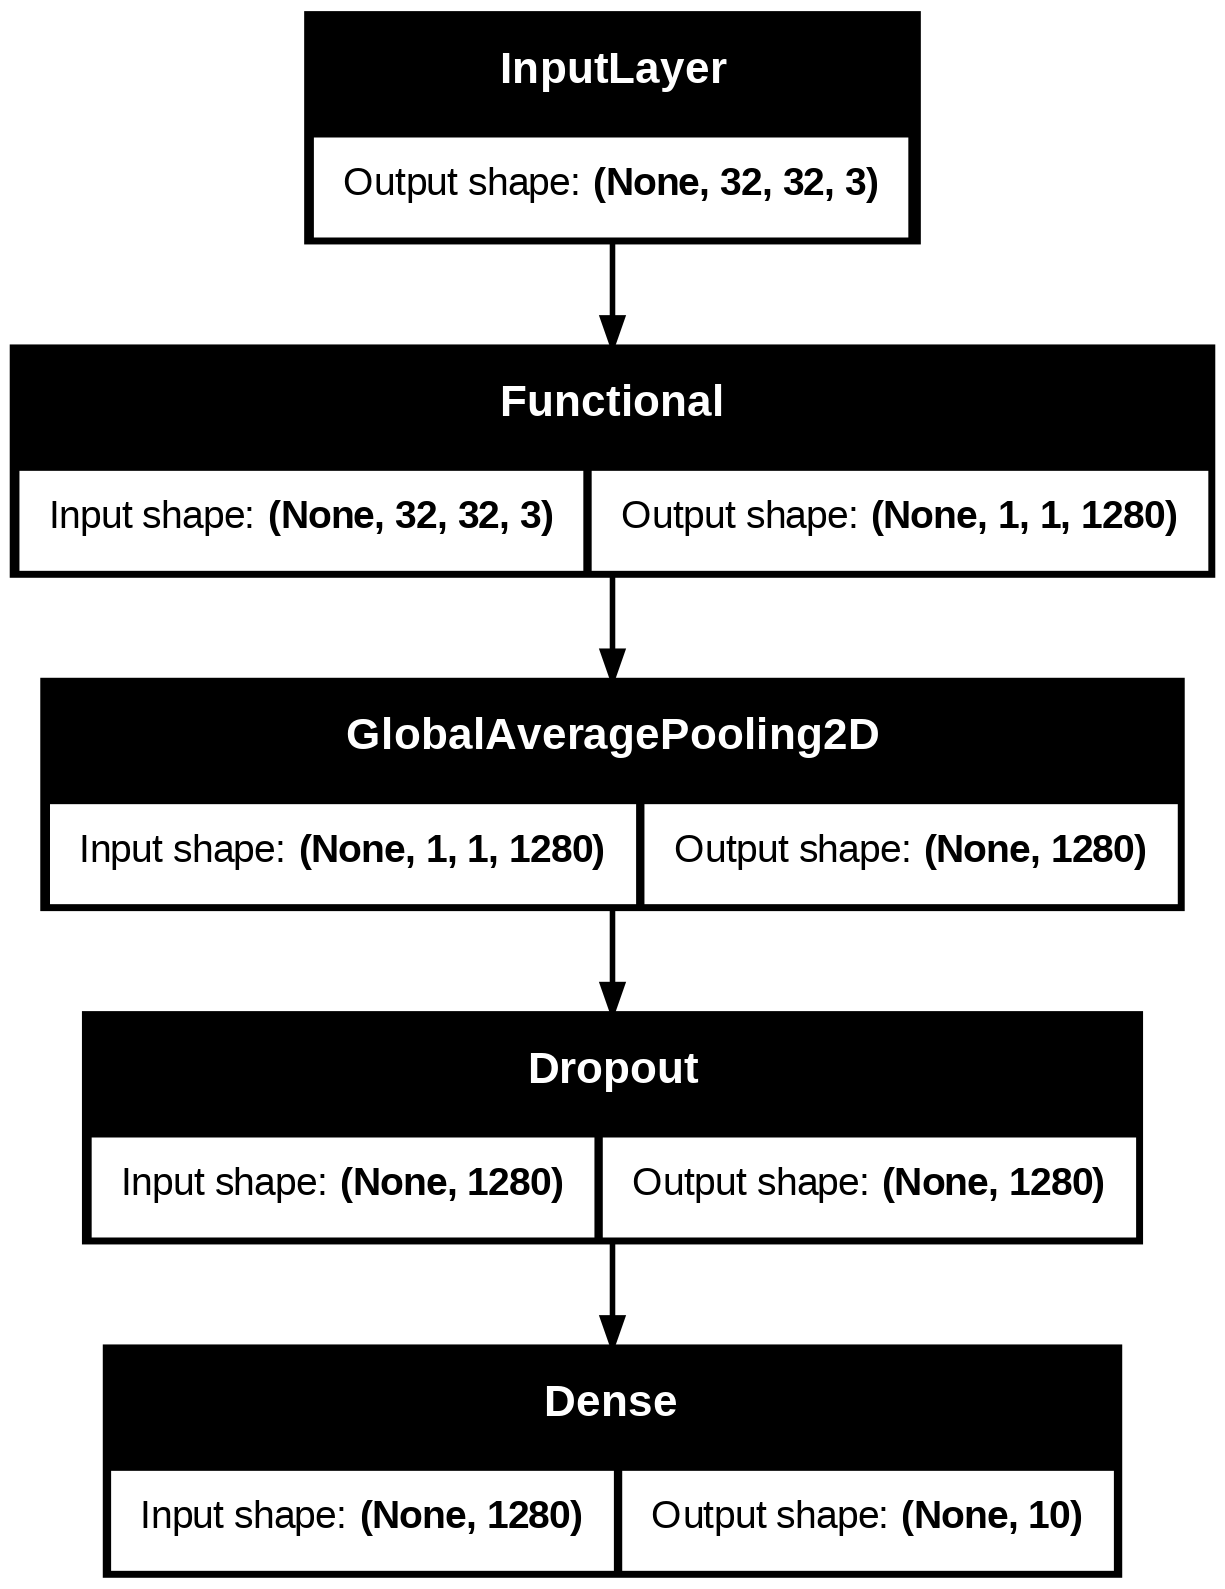

In [13]:
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

len(model.trainable_variables)
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


## Compile and fit the model

Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 25ms/step - accuracy: 0.3883 - loss: 1.7350 - val_accuracy: 0.5394 - val_loss: 1.3316 - learning_rate: 0.0010
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5069 - loss: 1.3923 - val_accuracy: 0.5495 - val_loss: 1.2814 - learning_rate: 0.0010
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5235 - loss: 1.3554 - val_accuracy: 0.5758 - val_loss: 1.2181 - learning_rate: 0.0010
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5280 - loss: 1.3332 - val_accuracy: 0.5748 - val_loss: 1.2095 - learning_rate: 0.0010
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5318 - loss: 1.3187 - val_accuracy: 0.5797 - val_loss: 1.1909 - learning_rate: 0.0010
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5325 - loss: 1.3110 - val_accuracy: 0.5774 - val_loss: 1.1866 - learning_rate: 0.0010
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accura

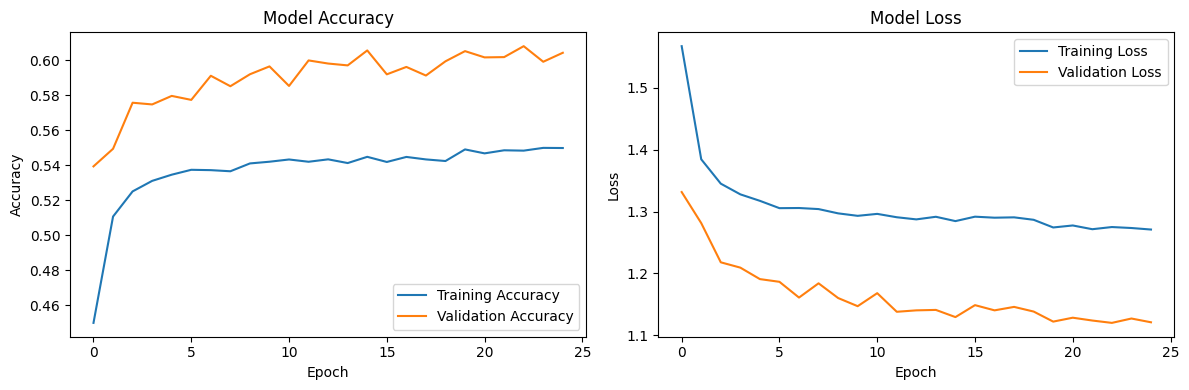

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)
]


# Step 4: Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Using one-hot encoded labels
    metrics=['accuracy']
)


# Step 5: Train the model
history = model.fit(
    x_train, y_train,
    epochs=25,
    validation_data=(x_train, y_train),
    callbacks = callbacks
)

# Step 6: Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_train, y_train)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Step 7: Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
##block of code used to clear keras sessions during development

from keras.backend import clear_session
clear_session()